### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

### 1.0 데이터 불러오기

In [32]:
file1 = pd.read_csv('폐기물_발생현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv', encoding = 'cp949')
file2 = pd.read_csv('폐기물 재활용률(09-18).csv', encoding = 'cp949')
file3 = pd.read_csv('폐기물_처리주체별_처리현황_생활계폐기물_생활폐기물_사업장생활계폐기물(10-19).csv', encoding = 'cp949')

In [83]:
# file1 전처리

# data1 = file1.transpose() #전치
# data1 = data1.reset_index() #인덱스초기화

# var = [str(elem)[0:4] for elem in data1['index'].values]
# data1['년도'] = var

# data1 = data1.drop('index', axis=1)
# data1 = data1[['년도',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]]
# data1.columns = ['년도', '배출방식', '종류1', '종류2', '합계', '서울','부산',	'대구',	'인천',	'광주','대전', '울산','세종','경기','강원','충북','충남','전북','전남','경북','경남','제주']
# data1 = data1.drop([0], axis = 0)

# 총계, 소계 행 삭제
# con2 = data1[data1['배출방식'] == '총계'].index
# con22 = data1[data1['종류2'] == '소계'].index
# data1.drop(con2, inplace=True)
# data1.drop(con22, inplace=True)

#인덱스 초기화
# data1 = data1.reset_index()
# data1 = data1.drop('level_0', axis=1)
# data1 = data1.drop('합계', axis=1)
# data1 = data1.drop('index', axis=1)

# melt
# data1 = data1.melt(id_vars=['년도','배출방식', '종류1', '종류2'])
# data1.columns = ['년도', '배출방식', '종류1', '종류2', '지역', '값']
                 
data1.head(10)

,년도,배출방식,종류1,종류2,지역,값
0,2010,종량제 방식에 의한 혼합 배출,가연성,음식물류폐기물,서울,10.9
1,2010,종량제 방식에 의한 혼합 배출,가연성,폐지류,서울,700.8
2,2010,종량제 방식에 의한 혼합 배출,가연성,폐목재류,서울,199.4
3,2010,종량제 방식에 의한 혼합 배출,가연성,폐고무류,서울,140.9
4,2010,종량제 방식에 의한 혼합 배출,가연성,플라스틱류,서울,366.0
5,2010,종량제 방식에 의한 혼합 배출,가연성,기타,서울,1919.1
6,2010,종량제 방식에 의한 혼합 배출,불연성,폐유리류,서울,31.9
7,2010,종량제 방식에 의한 혼합 배출,불연성,폐금속류,서울,24.2
8,2010,종량제 방식에 의한 혼합 배출,불연성,폐토사류,서울,128.0
9,2010,종량제 방식에 의한 혼합 배출,불연성,기타,서울,141.3


In [192]:
# file2 전처리


# melt 적용
# data2 = pd.melt(file2, id_vars=['행정구역별', '폐기물별', '항목','단위'])

# 의미없는 값 삭제
# con2 = data2[data2['variable'] == 'Unnamed: 14'].index
# data2.drop(con2, inplace=True)

# # 총계, 소계 행 삭제
# con2 = data2[data2['행정구역별'] == '총계'].index
# con22 = data2[data2['폐기물별'] == '합계'].index
# data2.drop(con2, inplace=True)
# data2.drop(con22, inplace=True)

##인덱스 초기화
# data2 = data2.reset_index()
# data2 = data2.drop('index', axis=1)

# data2 = data2.rename(columns={'variable': '년도', 'value': '값'}) #컬럼명 변경
# data2['년도'] = data2['년도'].str.replace(' 년','')  #년도 숫자만 남기기
# data2 = data2.drop('단위', axis=1) #필요없는 열 삭제

data2

,행정구역별,폐기물별,항목,년도,값
0,서울특별시,생활계폐기물,발생량[톤/일],2009,11445
1,서울특별시,생활계폐기물,재활용[톤/일],2009,7508
2,서울특별시,사업장배출시설계폐기물,발생량[톤/일],2009,2322
3,서울특별시,사업장배출시설계폐기물,재활용[톤/일],2009,869
4,서울특별시,건설폐기물,발생량[톤/일],2009,31774
...,...,...,...,...,...
24495,서귀포시,건설폐기물,재활용[톤/일],2018,897.3
24496,서귀포시,지정폐기물,발생량[톤/일],2018,3.8
24497,서귀포시,지정폐기물,재활용[톤/일],2018,0.6
24498,서귀포시,전년도이월량,발생량[톤/일],2018,0.0


In [87]:
# file3 전처리

# data3 = file3.transpose()  #전치
# data3 = data3.reset_index() #인덱스초기화

# var = [str(elem)[0:4] for elem in data3['index'].values] #년도 정제
# data3['년도'] = var #년도 컬럼추가

# #인덱스, 컬럼명 정리
# data3 = data3.drop('index', axis=1) 
# data3 = data3[['년도',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]]
# data3.columns = ['년도', '종류1', '종류2', '합계', '서울','부산','대구','인천','광주','대전', '울산','세종','경기','강원','충북','충남','전북','전남','경북','경남','제주']
# data3 = data3.drop([0], axis = 0)

# 총계, 소계 행 삭제
# con2 = data3[data3['종류1'] == '총계'].index
# con22 = data3[data3['종류2'] == '소계'].index
# data3.drop(con2, inplace=True)
# data3.drop(con22, inplace=True)

# #인덱스 초기화
# data3 = data3.reset_index()
# data3 = data3.drop('index', axis=1)
# data3 = data3.drop('합계', axis=1)

# melt
# data3 = data3.melt(id_vars=['년도', '종류1', '종류2'])
# data3.columns = ['년도', '종류1', '종류2', '지역', '값']

data3.head(10)

,년도,종류1,종류2,지역,값
0,2010,지방자치단체,매립,서울,962.2
1,2010,지방자치단체,소각,서울,1180.9
2,2010,지방자치단체,재활용,서울,3047.6
3,2010,위탁처리업체,매립,서울,483.5
4,2010,위탁처리업체,소각,서울,801.1
5,2010,위탁처리업체,재활용,서울,3544.0
6,2010,자가처리업체,매립,서울,0.0
7,2010,자가처리업체,소각,서울,0.0
8,2010,자가처리업체,재활용,서울,1.1
9,2011,지방자치단체,매립,서울,663.7


### 2.0 데이터 개요 

1. .info(), .head(), .describe() 등 데이터 전반 내용 확인

In [137]:
data1

,년도,배출방식,종류1,종류2,지역,값
0,2010,종량제 방식에 의한 혼합 배출,가연성,음식물류폐기물,서울,10.9
1,2010,종량제 방식에 의한 혼합 배출,가연성,폐지류,서울,700.8
2,2010,종량제 방식에 의한 혼합 배출,가연성,폐목재류,서울,199.4
3,2010,종량제 방식에 의한 혼합 배출,가연성,폐고무류,서울,140.9
4,2010,종량제 방식에 의한 혼합 배출,가연성,플라스틱류,서울,366.0
...,...,...,...,...,...,...
1882,2019,재활용가능자원 분리배출,폐합성수지류,발포수지류,제주,1.0
1883,2019,재활용가능자원 분리배출,폐합성수지류,PET병,제주,16.6
1884,2019,재활용가능자원 분리배출,폐합성수지류,기타,제주,12.8
1885,2019,재활용가능자원 분리배출,영농폐기물,농약용기류,제주,0.0


In [88]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      1887 non-null   object
 1   배출방식    1887 non-null   object
 2   종류1     1887 non-null   object
 3   종류2     1887 non-null   object
 4   지역      1887 non-null   object
 5   값       1887 non-null   object
dtypes: object(6)
memory usage: 88.6+ KB


In [167]:
data1.describe()

,값
count,1887.000000
mean,127.461049
std,214.679088
min,0.000000
25%,19.800000
50%,53.100000
75%,149.400000
max,2183.200000


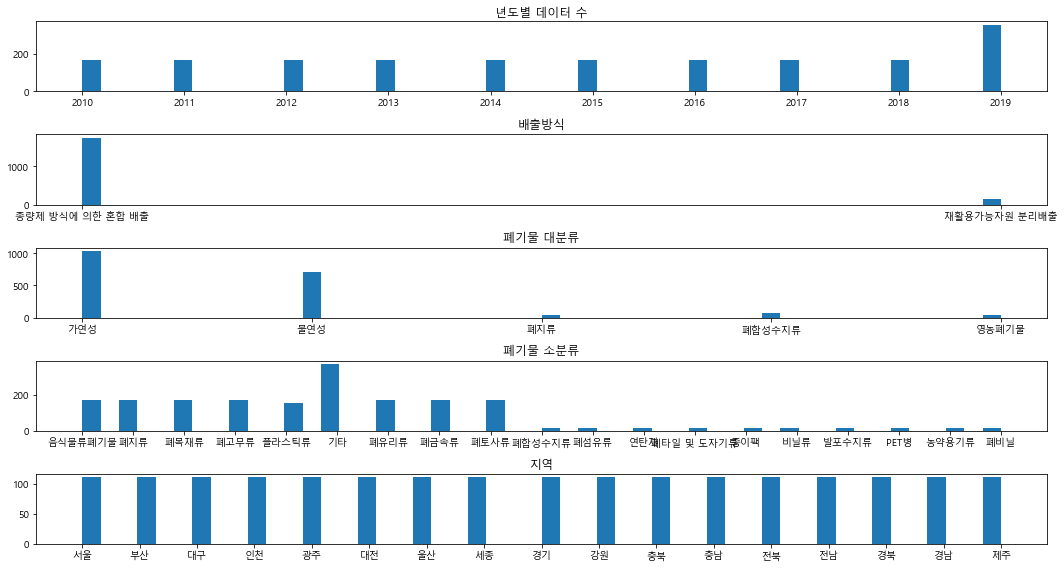

In [139]:
plt.figure(figsize=(15,8))

plt.subplot(5,1,1)
plt.hist(data1['년도'], bins=50)
plt.title('년도별 데이터 수')

plt.subplot(5,1,2)
plt.hist(data1['배출방식'], bins=50)
plt.title('배출방식')

plt.subplot(5,1,3)
plt.hist(data1['종류1'], bins=50)
plt.title('폐기물 대분류')

plt.subplot(5,1,4)
plt.hist(data1['종류2'], bins=50)
plt.title('폐기물 소분류')

plt.subplot(5,1,5)
plt.hist(data1['지역'], bins=50)
plt.title('지역')

plt.tight_layout()

In [177]:
# data1 = data1.replace('', '0')
# data1 = data1.astype({'값':float})
sum1 = data1.groupby(['년도', '지역'])['값'].sum()
sum1 = pd.DataFrame(sum1)

값
년도   지역        
2010 강원  1280.1
     경기  4584.3
     경남  1636.9
     경북  1322.5
     광주   524.5
...         ...
2019 전남  1456.9
     전북  1187.7
     제주   712.0
     충남  1783.7
     충북  1466.9

[170 rows x 1 columns]

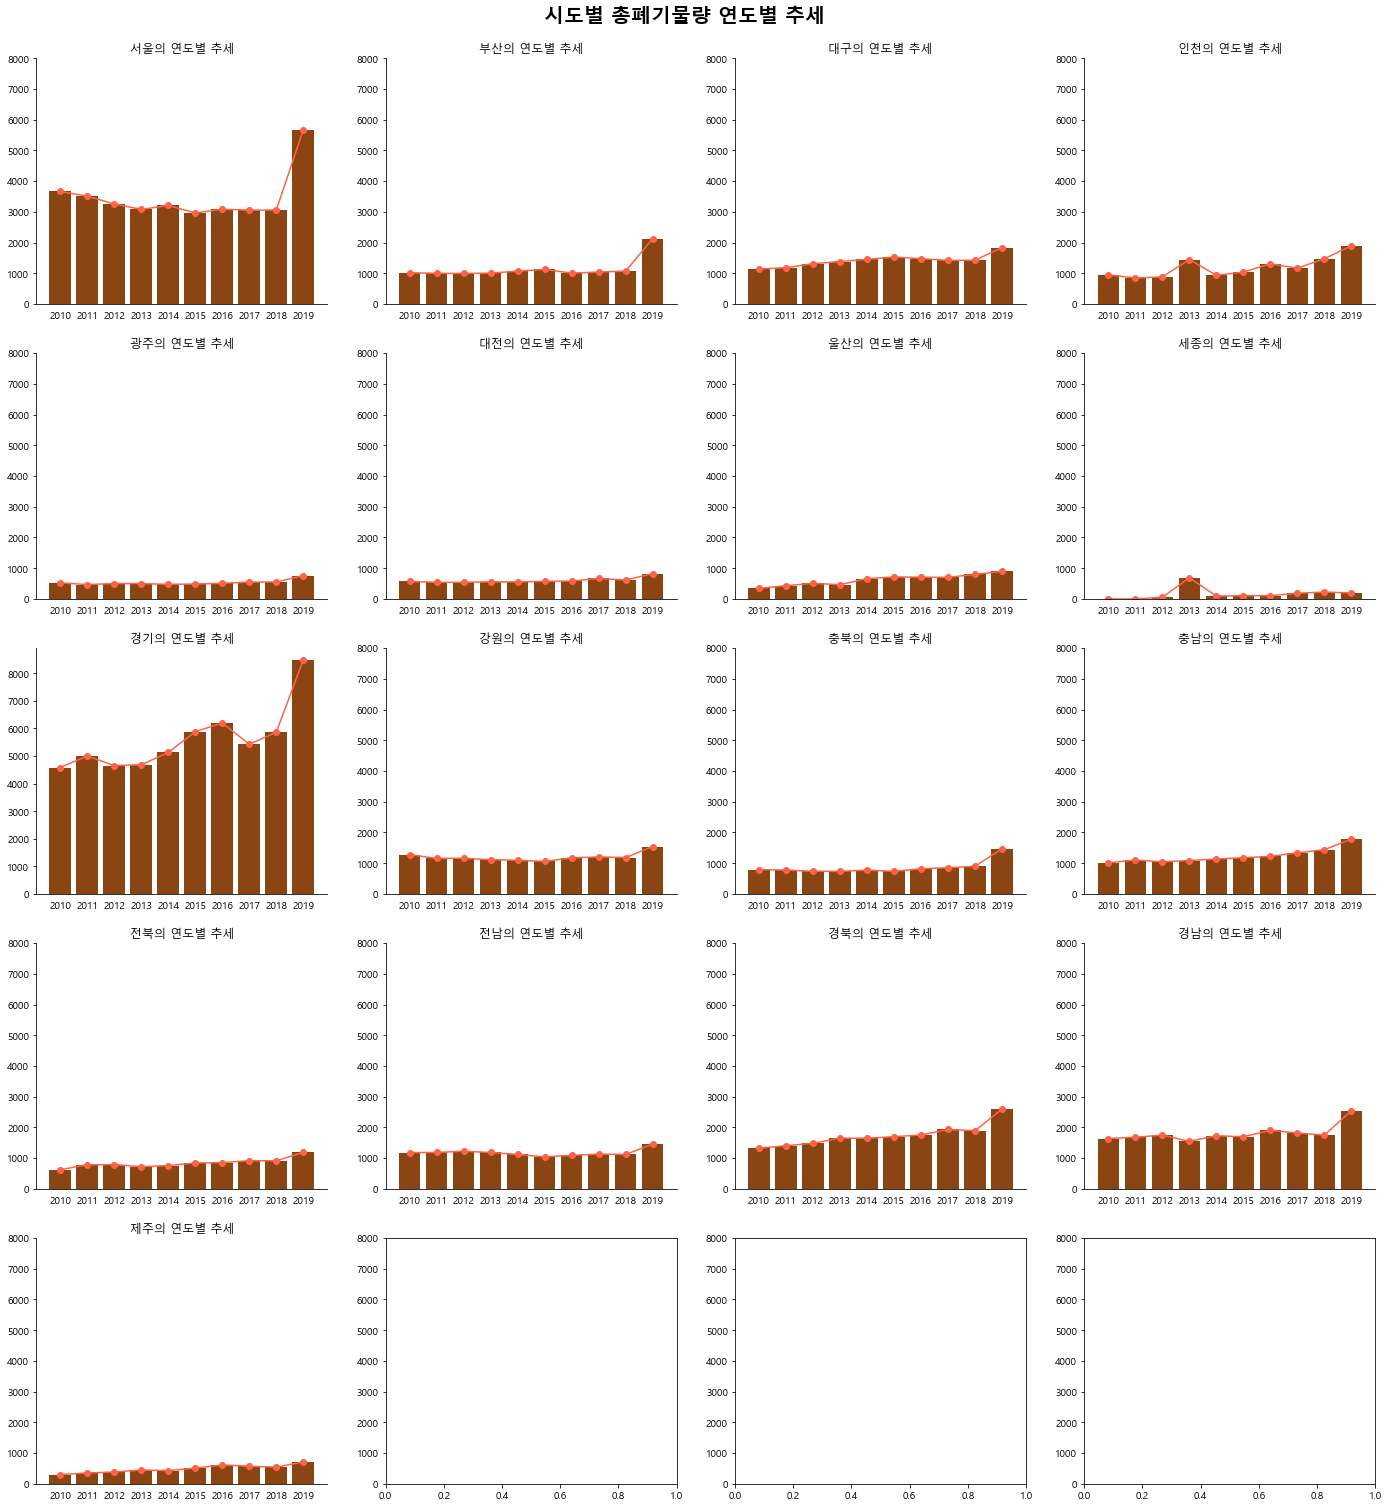

In [208]:
# 시도별 총폐기물량 연도별 추세

fig, axs = plt.subplots(5, 4, figsize=(24, 24))

ax, ay = 0, 0

for i in data1['지역'].unique():
    sido_condition = data1['지역']== i
    df_temp = data1[sido_condition].groupby(data1['년도'])[['값']].sum().reset_index()

    if ay==4:
        ax+=1
        ay=0
    axs[ax, ay].bar(df_temp['년도'], df_temp['값'], color='#8B4513')
    axs[ax, ay].plot(df_temp['년도'], df_temp['값'], color='#FF6347', marker='o')
    axs[ax, ay].set_title('{}의 연도별 추세'.format(i))
    axs[ax, ay].spines['top'].set_visible(False)
    axs[ax, ay].spines['right'].set_visible(False)
    axs[ax, ay].tick_params(bottom=False)
    ay+=1

for sax in axs.flat:
    sax.set_yticks(list(range(0, 9000, 1000)))
    # sax.set_xticks(list(data1['년도'].unique()))

plt.suptitle('시도별 총폐기물량 연도별 추세', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95)
plt.show()

In [209]:
# data2 = data2.replace('-', '0')
# data2 = data2.astype({'값':float})

print(data2.head(20))
data2.info()
data2.describe()

    행정구역별         폐기물별        항목    년도        값
0   서울특별시       생활계폐기물  발생량[톤/일]  2009  11445.0
1   서울특별시       생활계폐기물  재활용[톤/일]  2009   7508.0
2   서울특별시  사업장배출시설계폐기물  발생량[톤/일]  2009   2322.0
3   서울특별시  사업장배출시설계폐기물  재활용[톤/일]  2009    869.0
4   서울특별시        건설폐기물  발생량[톤/일]  2009  31774.0
5   서울특별시        건설폐기물  재활용[톤/일]  2009  30100.0
6   서울특별시        지정폐기물  발생량[톤/일]  2009    214.0
7   서울특별시        지정폐기물  재활용[톤/일]  2009     73.0
8   서울특별시       전년도이월량  발생량[톤/일]  2009      9.0
9   서울특별시      당해년도발생량  발생량[톤/일]  2009    205.0
10    종로구       생활계폐기물  발생량[톤/일]  2009    433.0
11    종로구       생활계폐기물  재활용[톤/일]  2009    273.0
12    종로구  사업장배출시설계폐기물  발생량[톤/일]  2009      0.0
13    종로구  사업장배출시설계폐기물  재활용[톤/일]  2009      0.0
14    종로구        건설폐기물  발생량[톤/일]  2009    645.0
15    종로구        건설폐기물  재활용[톤/일]  2009    610.0
16    종로구        지정폐기물  발생량[톤/일]  2009      3.0
17    종로구        지정폐기물  재활용[톤/일]  2009      1.0
18    종로구       전년도이월량  발생량[톤/일]  2009      0.0
19    종로구      당해년도발생량  발생량[톤/일]  2009  

,값
count,2.438500e+04
mean,8.841749e+03
std,9.793576e+04
min,0.000000e+00
25%,1.340000e+01
50%,1.624000e+02
75%,6.888000e+02
max,4.902572e+06


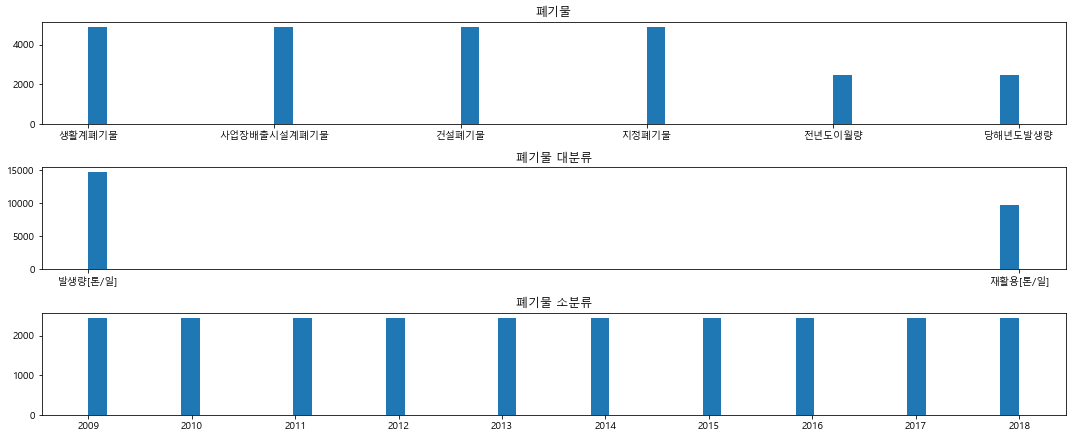

In [203]:
# 항목별 데이터 수 

plt.figure(figsize=(15,8))

plt.subplot(4,1,2)
plt.hist(data2['폐기물별'], bins=50)
plt.title('폐기물')

plt.subplot(4,1,3)
plt.hist(data2['항목'], bins=50)
plt.title('폐기물 대분류')

plt.subplot(4,1,4)
plt.hist(data2['년도'], bins=50)
plt.title('폐기물 소분류')

plt.tight_layout()

In [219]:
# data3 = data3.replace('-', '0')
# data3 = data3.astype({'값':float})

print(data3.head(10))
data3.info()
data3.describe()

     년도     종류1  종류2  지역       값
0  2010  지방자치단체   매립  서울   962.2
1  2010  지방자치단체   소각  서울  1180.9
2  2010  지방자치단체  재활용  서울  3047.6
3  2010  위탁처리업체   매립  서울   483.5
4  2010  위탁처리업체   소각  서울   801.1
5  2010  위탁처리업체  재활용  서울  3544.0
6  2010  자가처리업체   매립  서울     0.0
7  2010  자가처리업체   소각  서울     0.0
8  2010  자가처리업체  재활용  서울     1.1
9  2011  지방자치단체   매립  서울   663.7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      1581 non-null   object 
 1   종류1     1581 non-null   object 
 2   종류2     1581 non-null   object 
 3   지역      1581 non-null   object 
 4   값       1581 non-null   float64
dtypes: float64(1), object(4)
memory usage: 61.9+ KB


,값
count,1581.000000
mean,327.786970
std,648.407647
min,0.000000
25%,0.100000
50%,35.400000
75%,419.100000
max,5480.100000


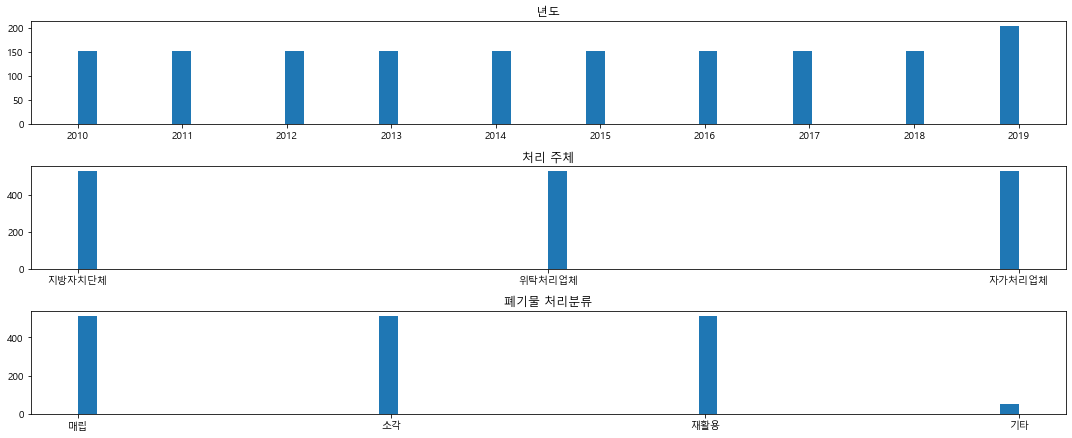

In [222]:
# 항목별 데이터 수 

plt.figure(figsize=(15,8))

plt.subplot(4,1,2)
plt.hist(data3['년도'], bins=50)
plt.title('년도')

plt.subplot(4,1,3)
plt.hist(data3['종류1'], bins=50)
plt.title('처리 주체')

plt.subplot(4,1,4)
plt.hist(data3['종류2'], bins=50)
plt.title('폐기물 처리분류')

plt.tight_layout()

### 3.0 시각적 EDA

데이터 분포, 널값 비율, 또는 데이터 특성이 나타나는 항목 등 시각화 필요한 부분 시각화